# **Предобработка датасета**

# Считывание данных и простейшая предобработка

Загрузим необходимые библиотеки.

In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Считаем данные из файла и **исправим некорректные строчки**, где разделителей - запятых - больше, чем столбцов предполагаемого датафрейма. Запишем результат в датафрейм.

In [154]:
with open('/content/drive/MyDrive/Colab Notebooks/визуализация/goodreads-books-dataset.csv', 'r') as data_file:
  lines = data_file.readlines()

ind = 0
while ind < len(lines):
  s = lines[ind].strip()
  s_split = s.split(',')
  if len(s_split) != 12:
    print(ind, s)
  ind += 1

3349 12224,Streetcar Suburbs: The Process of Growth in Boston  1870-1900,Sam Bass Warner, Jr./Sam B. Warner,3.58,0674842111,9780674842113,en-US,236,61,6,4/20/2004,Harvard University Press
4703 16914,The Tolkien Fan's Medieval Reader,David E. Smith (Turgon of TheOneRing.net, one of the founding members of this Tolkien website)/Verlyn Flieger/Turgon (=David E. Smith),3.58,1593600119,9781593600112,eng,400,26,4,4/6/2004,Cold Spring Press
5878 22128,Patriots (The Coming Collapse),James Wesley, Rawles,3.63,156384155X,9781563841552,eng,342,38,4,1/15/1999,Huntington House Publishers
8980 34889,Brown's Star Atlas: Showing All The Bright Stars With Full Instructions How To Find And Use Them For Navigational Purposes And Department Of Trade Examinations.,Brown, Son & Ferguson,0.00,0851742718,9780851742717,eng,49,0,0,5/1/1977,Brown Son & Ferguson Ltd.


In [155]:
lines[3349] = '12224,Streetcar Suburbs: The Process of Growth in Boston  1870-1900,Sam Bass Warner Jr./Sam B. Warner,3.58,0674842111,9780674842113,en-US,236,61,6,4/20/2004,Harvard University Press\n'
lines[4703] = "16914,The Tolkien Fan's Medieval Reader,David E. Smith/Verlyn Flieger,3.58,1593600119,9781593600112,eng,400,26,4,4/6/2004,Cold Spring Press\n"
lines[5878] = "22128,Patriots (The Coming Collapse),James Wesley Rawles,3.63,156384155X,9781563841552,eng,342,38,4,1/15/1999,Huntington House Publishers\n"
lines[8980] = "34889,Brown's Star Atlas: Showing All The Bright Stars With Full Instructions How To Find And Use Them For Navigational Purposes And Department Of Trade Examinations.,Brown Son & Ferguson,0.00,0851742718,9780851742717,eng,49,0,0,5/1/1977,Brown Son & Ferguson Ltd.\n"

In [208]:
from io import StringIO
df = pd.read_csv(StringIO(''.join(lines)), delim_whitespace=False)
df.rename(columns={'  num_pages': 'num_pages'}, inplace=True)
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


Проверим, что первоначально некорректные строки распознались верно.

In [157]:
df[df['bookID'] == 12224]

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
3348,12224,Streetcar Suburbs: The Process of Growth in Bo...,Sam Bass Warner Jr./Sam B. Warner,3.58,0674842111,9780674842113,en-US,236,61,6,4/20/2004,Harvard University Press


Посмотрим, есть ли в датасете **пропущенные значения**, - их нет:

In [158]:
for col in df:
  print(df[col].isna().sum())

0
0
0
0
0
0
0
0
0
0
0
0


**Удалим столбцы с кодами ISBN**, поскольку они не несут информации, которую можно использовать для анализа данных.

In [209]:
df = df.drop(columns=['isbn', 'isbn13'])

Распознаем ячейки столбца с **именами авторов** как массивы строк и добавим столбец с числом авторов.

In [210]:
df['authors'] = df['authors'].str.split('/')
df['authors_number'] = df['authors'].agg(len)

Посмотрим на результат:

In [239]:
df.head()

,bookID,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,authors_number
0,1,Harry Potter and the Half-Blood Prince (Harry ...,"[J.K. Rowling, Mary GrandPré]",4.57,eng,652,2095690,27591,2006-09-16,Scholastic Inc.,2
1,2,Harry Potter and the Order of the Phoenix (Har...,"[J.K. Rowling, Mary GrandPré]",4.49,eng,870,2153167,29221,2004-09-01,Scholastic Inc.,2
2,4,Harry Potter and the Chamber of Secrets (Harry...,[J.K. Rowling],4.42,eng,352,6333,244,2003-11-01,Scholastic,1
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,"[J.K. Rowling, Mary GrandPré]",4.56,eng,435,2339585,36325,2004-05-01,Scholastic Inc.,2
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,"[J.K. Rowling, Mary GrandPré]",4.78,eng,2690,41428,164,2004-09-13,Scholastic,2


# Предобработка дат

Приведем столбец с **датами публикации книг** к типу данных datetime, предварительно исправив некорректные 
значения.

In [162]:
def incorrect_date(day, month, year):
  if day <= 0 or month <= 0 or year < 0:
    return True
  
  if month in (1, 3, 5, 7, 8, 10, 12) and day > 31:
    return True

  if month in (4, 6, 9, 11) and day > 30:
    return True

  if month == 2:
    if year % 400 == 0 or (year % 100 != 0 and year % 4 == 0):
      if day > 29:
        return True
    elif day > 28:
      return True

  return False

In [180]:
for ind, row in df.iterrows():
  month, day, year = map(int, row['publication_date'].split('/'))
  if incorrect_date(day, month, year):
    print(row['bookID'], row['publication_date'])

31373 11/31/2000
45531 6/31/1982


In [211]:
df.loc[df['bookID'] == 31373, 'publication_date'] = '11/30/2000'
df.loc[df['bookID'] == 45531, 'publication_date'] = '6/30/1982'

In [212]:
df['publication_date'] = pd.to_datetime(df['publication_date'], format='%m/%d/%Y')
df.dtypes

bookID                         int64
title                         object
authors                       object
average_rating               float64
language_code                 object
num_pages                      int64
ratings_count                  int64
text_reviews_count             int64
publication_date      datetime64[ns]
publisher                     object
dtype: object

# Предобработка столбца с языковыми кодами

В датафрейме используются несколько различных кодов для английского языка:

In [167]:
df['language_code'].unique()

array(['eng', 'en-US', 'fre', 'spa', 'en-GB', 'mul', 'grc', 'enm',
       'en-CA', 'ger', 'jpn', 'ara', 'nl', 'zho', 'lat', 'por', 'srp',
       'ita', 'rus', 'msa', 'glg', 'wel', 'swe', 'nor', 'tur', 'gla',
       'ale'], dtype=object)

In [213]:
df[df['language_code'].str.contains('en')].groupby('language_code')['bookID'].count()

language_code
en-CA       7
en-GB     214
en-US    1409
eng      8911
enm         3
Name: bookID, dtype: int64

Приведем их все к одному виду - просто 'eng':

In [214]:
df.loc[df['language_code'].str.contains('en'), 'language_code'] = 'eng'
df['language_code'].unique()

array(['eng', 'fre', 'spa', 'mul', 'grc', 'ger', 'jpn', 'ara', 'nl',
       'zho', 'lat', 'por', 'srp', 'ita', 'rus', 'msa', 'glg', 'wel',
       'swe', 'nor', 'tur', 'gla', 'ale'], dtype=object)

# Замена некорректных нулевых значений

В датафрейме есть книги, у которых **число поставленных рейтингов равно нулю**, в то время как **средний рейтинг нулю не равен**. 

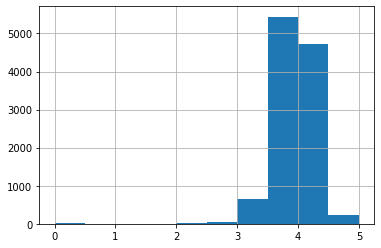

In [203]:
df['average_rating'].hist();

Таких книг 55:

In [215]:
df[(df['ratings_count'] == 0) & (df['average_rating'] != 0)]['bookID'].size

55

Для таких книг в столбец с числом проставленных рейтингов запишем медианное значение по числу проставленных рейтингов среди книг со средним рейтингом в том же диапазоне.

In [216]:
precision = 0.1
iter_range = np.arange(0.1, 5.1, precision)

median_ratings_count = dict()
for i in iter_range:
  i = round(i,1)
  value = df[(i - precision <= df['average_rating']) 
    & (df['average_rating'] <= i)]['ratings_count'].median()
  if np.isnan(value):
    value = 0
  median_ratings_count[i] = round(value)

median_ratings_count = pd.Series(median_ratings_count)
median_ratings_count = median_ratings_count.replace(0, round(median_ratings_count.mean()))
median_ratings_count

0.1     285
0.2     285
0.3     285
0.4     285
0.5     285
0.6     285
0.7     285
0.8     285
0.9     285
1.0       2
1.1       2
1.2     285
1.3     285
1.4     285
1.5     285
1.6     285
1.7       3
1.8     285
1.9     285
2.0       1
2.1       1
2.2     285
2.3     285
2.4    2709
2.5    2710
2.6      18
2.7       8
2.8       8
2.9      79
3.0       6
3.1      12
3.2     124
3.3     140
3.4     218
3.5     332
3.6     329
3.7     546
3.8     657
3.9     912
4.0     832
4.1    1005
4.2    1148
4.3     817
4.4     675
4.5     505
4.6     135
4.7     178
4.8     144
4.9       7
5.0       2
dtype: int64

In [ ]:
for _, row in df.iterrows():
  if row['ratings_count'] == 0 and row['average_rating'] != 0:
    rating = round(row['average_rating'] + 0.05, 1)
    df.loc[_, 'ratings_count'] = median_ratings_count[rating]

Проверим, что в датафрейме не осталось строк, где число проставленных рейтингов равно нулю, а сам средний рейтинг - нет:

In [220]:
df[(df['ratings_count'] == 0) & (df['average_rating'] != 0)]['bookID'].size

0

# Гипотезы о данных

Столбцы ratings_count и text_reviews_count достаточно сильно коррелируют.

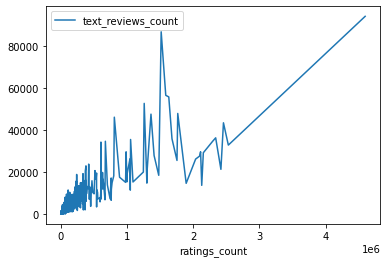

In [225]:
df[['ratings_count', 'text_reviews_count']].sort_values(by='ratings_count') \
  .plot(x='ratings_count', y='text_reviews_count');
plt.savefig('texts_rates.jpg')

Пользователи Goodreads практически не читают книги длиной более 1500 страниц.

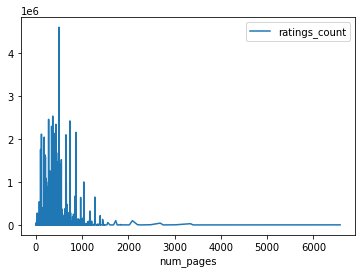

In [231]:
df[['ratings_count', 'num_pages']].sort_values(by='num_pages') \
  .plot(x='num_pages', y='ratings_count');
plt.savefig('num_pages_rates.jpg')